In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

In [2]:
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from utils.helper import *

In [3]:
df = pd.read_csv("../../data/Final_Btc_Data_with_Indicators.csv", parse_dates=['Date'])

target_col = "Price"
features = [col for col in df.columns if col != target_col and col != "Date"]

df = scaled_data(df)

seq_len = 15
horizon = 1
X, y = create_sequences(df[features].values, df[target_col].values, seq_len, horizon)

/Users/sohamsamal/Documents/Coding/Research/research-btc-pred/venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
batch_size = 256

train_loader, val_loader, test_loader = data_loaders(df, X, y, batch_size=batch_size)

In [5]:
class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, num_filters=32, num_bilstm_layers=2, lstm_hidden=64, filter_size=(10, 1), input_lstm_dim=100, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_dim,
            out_channels=num_filters,
            kernel_size=filter_size[0],
            stride=1,
            padding=filter_size[0] // 2
        )

        self.proj = nn.Linear(num_filters, input_lstm_dim)

        self.relu = nn.ReLU()

        self.bilstm1 = nn.LSTM(
            input_size=input_lstm_dim,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.drop1 = nn.Dropout(dropout_rate)

        self.bilstm2 = nn.LSTM(
            input_size = 2 * lstm_hidden,
            hidden_size=lstm_hidden,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_hidden * 2, 1)


    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))

        x = x.permute(0, 2, 1)
        x = self.relu(self.proj(x))

        # BiLSTM layers
        out, _ = self.bilstm1(x)
        out = self.drop1(out)
        out, _ = self.bilstm2(out)

        # take last time step
        out = out[:, -1, :]
        out = self.fc(out)
        return out.squeeze(-1)

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [7]:
model = CNNBiLSTM(input_dim=len(features))

In [8]:
decay_rate = 0.8
num_epochs = 500
learning_rate = 0.001
l2_penalty = 0.001

In [9]:
# Training the model using the train_loader, val_loader, and test_loader
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    # weight_decay=l2_penalty
)

num_epochs = 300
best_val_loss = float('inf')
patience = 30
patience_counter = 0

# Load existing model's best validation loss if it exists
existing_model_path = '../../models/temp_models/cnn_bilstm15.pth'
existing_best_val_loss = float('inf')

if os.path.exists(existing_model_path):
    try:
        # Create a temporary model to load and evaluate the existing model
        temp_lstm = CNNBiLSTM(input_dim=len(features)).to(device)
        temp_lstm.load_state_dict(torch.load(existing_model_path))
        temp_lstm.eval()

        # Evaluate existing model on validation set
        existing_val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = temp_lstm(batch_x)
                loss = criterion(outputs, batch_y)
                existing_val_loss += loss.item()

        existing_best_val_loss = existing_val_loss / len(val_loader)
        print(f"Existing model validation loss: {existing_best_val_loss:.6f}")

        # Delete temporary model to free memory
        del temp_lstm
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    except Exception as e:
        print(f"Could not load existing model: {e}")
        existing_best_val_loss = float('inf')

train_losses = []
val_losses = []

print(f"Training on device: {device}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

for epoch in range(num_epochs):

    print(f"{'='*40}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'-'*40}")

    model.train()
    train_loss = 0.0

    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in tqdm(val_loader):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')

    # Early stopping check
    if patience_counter >= patience:
        print(f'Early stopping triggered after epoch {epoch+1}')
        break

# After training is complete, compare with existing model and save only if better
if best_val_loss < existing_best_val_loss:
    torch.save(model.state_dict(), existing_model_path)
    print(f'\nNew model is better! Saved with validation loss: {best_val_loss:.6f}')
    print(f'Previous best was: {existing_best_val_loss:.6f}')
else:
    print(f'\nExisting model is better. Not saving new model.')
    print(f'New model validation loss: {best_val_loss:.6f}')
    print(f'Existing model validation loss: {existing_best_val_loss:.6f}')

print(f'\nBest validation loss achieved this training: {best_val_loss:.6f}')

Existing model validation loss: 0.661810
Training on device: mps
Model parameters: 192261
Epoch 1/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 101.10it/s]


Epoch [1/300] - Train Loss: 1.312533, Val Loss: 19.786391
Epoch 2/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 170.40it/s]


Epoch [2/300] - Train Loss: 1.003028, Val Loss: 17.053519
Epoch 3/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 171.14it/s]


Epoch [3/300] - Train Loss: 0.757492, Val Loss: 13.721594
Epoch 4/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 165.77it/s]


Epoch [4/300] - Train Loss: 0.528100, Val Loss: 9.238458
Epoch 5/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 90.73it/s]


Epoch [5/300] - Train Loss: 0.387192, Val Loss: 5.450826
Epoch 6/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 165.63it/s]


Epoch [6/300] - Train Loss: 0.221051, Val Loss: 3.465406
Epoch 7/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 178.71it/s]


Epoch [7/300] - Train Loss: 0.111827, Val Loss: 1.433519
Epoch 8/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.04it/s]


Epoch [8/300] - Train Loss: 0.058285, Val Loss: 0.553710
Epoch 9/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 120.86it/s]


Epoch [9/300] - Train Loss: 0.033105, Val Loss: 0.276913
Epoch 10/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 95.97it/s]


Epoch [10/300] - Train Loss: 0.020996, Val Loss: 0.349409
Epoch 11/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 93.77it/s]


Epoch [11/300] - Train Loss: 0.046783, Val Loss: 0.527531
Epoch 12/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 71.78it/s]


Epoch [12/300] - Train Loss: 0.421008, Val Loss: 3.463950
Epoch 13/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 134.20it/s]


Epoch [13/300] - Train Loss: 0.079404, Val Loss: 0.406236
Epoch 14/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 132.54it/s]


Epoch [14/300] - Train Loss: 0.059149, Val Loss: 0.470767
Epoch 15/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 136.01it/s]


Epoch [15/300] - Train Loss: 0.030683, Val Loss: 0.272724
Epoch 16/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 123.23it/s]


Epoch [16/300] - Train Loss: 0.018179, Val Loss: 0.264222
Epoch 17/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.61it/s]


Epoch [17/300] - Train Loss: 0.013547, Val Loss: 0.411635
Epoch 18/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 173.93it/s]


Epoch [18/300] - Train Loss: 0.016596, Val Loss: 0.634334
Epoch 19/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 158.58it/s]


Epoch [19/300] - Train Loss: 0.101002, Val Loss: 0.257916
Epoch 20/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.25it/s]


Epoch [20/300] - Train Loss: 0.151354, Val Loss: 1.984828
Epoch 21/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 124.94it/s]


Epoch [21/300] - Train Loss: 0.055648, Val Loss: 0.372035
Epoch 22/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 103.80it/s]


Epoch [22/300] - Train Loss: 0.027178, Val Loss: 0.370598
Epoch 23/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 98.26it/s]


Epoch [23/300] - Train Loss: 0.023731, Val Loss: 0.665281
Epoch 24/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 38.42it/s]


Epoch [24/300] - Train Loss: 0.017617, Val Loss: 0.477322
Epoch 25/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.60it/s]


Epoch [25/300] - Train Loss: 0.014763, Val Loss: 0.434719
Epoch 26/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 160.71it/s]


Epoch [26/300] - Train Loss: 0.012090, Val Loss: 0.585651
Epoch 27/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 82.55it/s]


Epoch [27/300] - Train Loss: 0.011645, Val Loss: 0.561798
Epoch 28/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 165.55it/s]


Epoch [28/300] - Train Loss: 0.010710, Val Loss: 0.590485
Epoch 29/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 36.81it/s]


Epoch [29/300] - Train Loss: 0.008757, Val Loss: 0.688482
Epoch 30/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 47.58it/s]


Epoch [30/300] - Train Loss: 0.008702, Val Loss: 0.575107
Epoch 31/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 127.03it/s]


Epoch [31/300] - Train Loss: 0.008149, Val Loss: 0.658156
Epoch 32/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 90.96it/s]


Epoch [32/300] - Train Loss: 0.007238, Val Loss: 0.524147
Epoch 33/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 109.58it/s]


Epoch [33/300] - Train Loss: 0.006905, Val Loss: 0.644730
Epoch 34/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 115.81it/s]


Epoch [34/300] - Train Loss: 0.007109, Val Loss: 0.512694
Epoch 35/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.01it/s]


Epoch [35/300] - Train Loss: 0.010305, Val Loss: 0.740347
Epoch 36/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 79.89it/s]


Epoch [36/300] - Train Loss: 0.019558, Val Loss: 0.298912
Epoch 37/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 158.91it/s]


Epoch [37/300] - Train Loss: 0.054634, Val Loss: 1.395340
Epoch 38/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 170.79it/s]


Epoch [38/300] - Train Loss: 0.052377, Val Loss: 0.189956
Epoch 39/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 156.10it/s]


Epoch [39/300] - Train Loss: 0.030119, Val Loss: 1.138260
Epoch 40/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 163.77it/s]


Epoch [40/300] - Train Loss: 0.010276, Val Loss: 0.313003
Epoch 41/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 102.05it/s]


Epoch [41/300] - Train Loss: 0.010599, Val Loss: 0.349171
Epoch 42/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 116.35it/s]


Epoch [42/300] - Train Loss: 0.010394, Val Loss: 0.612072
Epoch 43/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 116.98it/s]


Epoch [43/300] - Train Loss: 0.007710, Val Loss: 0.400179
Epoch 44/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 161.94it/s]


Epoch [44/300] - Train Loss: 0.007328, Val Loss: 0.525080
Epoch 45/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 156.18it/s]


Epoch [45/300] - Train Loss: 0.006506, Val Loss: 0.523421
Epoch 46/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 170.66it/s]


Epoch [46/300] - Train Loss: 0.006507, Val Loss: 0.547022
Epoch 47/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 117.37it/s]


Epoch [47/300] - Train Loss: 0.007008, Val Loss: 0.445022
Epoch 48/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 81.73it/s]


Epoch [48/300] - Train Loss: 0.006775, Val Loss: 0.545436
Epoch 49/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 113.01it/s]


Epoch [49/300] - Train Loss: 0.005939, Val Loss: 0.513196
Epoch 50/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 119.35it/s]


Epoch [50/300] - Train Loss: 0.006462, Val Loss: 0.567203
Epoch 51/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 67.12it/s]


Epoch [51/300] - Train Loss: 0.006587, Val Loss: 0.383183
Epoch 52/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 122.23it/s]


Epoch [52/300] - Train Loss: 0.007552, Val Loss: 0.645827
Epoch 53/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 108.25it/s]


Epoch [53/300] - Train Loss: 0.009617, Val Loss: 0.294925
Epoch 54/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 92.38it/s]


Epoch [54/300] - Train Loss: 0.019647, Val Loss: 0.916068
Epoch 55/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 120.74it/s]


Epoch [55/300] - Train Loss: 0.031164, Val Loss: 0.139206
Epoch 56/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 108.09it/s]


Epoch [56/300] - Train Loss: 0.049529, Val Loss: 1.440661
Epoch 57/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 75.03it/s]


Epoch [57/300] - Train Loss: 0.036100, Val Loss: 0.151027
Epoch 58/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 128.07it/s]


Epoch [58/300] - Train Loss: 0.016352, Val Loss: 0.937759
Epoch 59/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 79.24it/s]


Epoch [59/300] - Train Loss: 0.008247, Val Loss: 0.421302
Epoch 60/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 99.55it/s]


Epoch [60/300] - Train Loss: 0.006967, Val Loss: 0.445261
Epoch 61/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 121.69it/s]


Epoch [61/300] - Train Loss: 0.006542, Val Loss: 0.628685
Epoch 62/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 39.74it/s]


Epoch [62/300] - Train Loss: 0.005491, Val Loss: 0.492121
Epoch 63/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 46.34it/s]


Epoch [63/300] - Train Loss: 0.005672, Val Loss: 0.578292
Epoch 64/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 141.66it/s]


Epoch [64/300] - Train Loss: 0.005841, Val Loss: 0.516435
Epoch 65/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 101.65it/s]


Epoch [65/300] - Train Loss: 0.005071, Val Loss: 0.472824
Epoch 66/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 154.67it/s]


Epoch [66/300] - Train Loss: 0.005050, Val Loss: 0.526983
Epoch 67/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.80it/s]


Epoch [67/300] - Train Loss: 0.005147, Val Loss: 0.414366
Epoch 68/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 114.70it/s]


Epoch [68/300] - Train Loss: 0.005820, Val Loss: 0.567956
Epoch 69/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 43.10it/s]


Epoch [69/300] - Train Loss: 0.006203, Val Loss: 0.363798
Epoch 70/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 163.36it/s]


Epoch [70/300] - Train Loss: 0.008887, Val Loss: 0.742385
Epoch 71/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 74.54it/s]


Epoch [71/300] - Train Loss: 0.014744, Val Loss: 0.240951
Epoch 72/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 144.47it/s]


Epoch [72/300] - Train Loss: 0.028074, Val Loss: 1.154059
Epoch 73/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 140.19it/s]


Epoch [73/300] - Train Loss: 0.031838, Val Loss: 0.132288
Epoch 74/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 152.19it/s]


Epoch [74/300] - Train Loss: 0.032220, Val Loss: 1.278946
Epoch 75/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 133.08it/s]


Epoch [75/300] - Train Loss: 0.019956, Val Loss: 0.207496
Epoch 76/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 82.88it/s]


Epoch [76/300] - Train Loss: 0.010594, Val Loss: 0.808702
Epoch 77/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 100.79it/s]


Epoch [77/300] - Train Loss: 0.006416, Val Loss: 0.460909
Epoch 78/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 155.96it/s]


Epoch [78/300] - Train Loss: 0.005505, Val Loss: 0.490198
Epoch 79/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 162.34it/s]


Epoch [79/300] - Train Loss: 0.004725, Val Loss: 0.519623
Epoch 80/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 156.81it/s]


Epoch [80/300] - Train Loss: 0.004406, Val Loss: 0.511576
Epoch 81/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 163.21it/s]


Epoch [81/300] - Train Loss: 0.004476, Val Loss: 0.523610
Epoch 82/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 160.81it/s]


Epoch [82/300] - Train Loss: 0.004440, Val Loss: 0.570711
Epoch 83/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 143.53it/s]


Epoch [83/300] - Train Loss: 0.004729, Val Loss: 0.472724
Epoch 84/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 158.64it/s]


Epoch [84/300] - Train Loss: 0.004240, Val Loss: 0.567557
Epoch 85/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 41.49it/s]


Epoch [85/300] - Train Loss: 0.004138, Val Loss: 0.507378
Epoch 86/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 90.74it/s]


Epoch [86/300] - Train Loss: 0.004694, Val Loss: 0.486619
Epoch 87/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 155.63it/s]


Epoch [87/300] - Train Loss: 0.004157, Val Loss: 0.461819
Epoch 88/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 126.56it/s]


Epoch [88/300] - Train Loss: 0.004446, Val Loss: 0.515701
Epoch 89/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 166.55it/s]


Epoch [89/300] - Train Loss: 0.004039, Val Loss: 0.530604
Epoch 90/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 141.75it/s]


Epoch [90/300] - Train Loss: 0.004093, Val Loss: 0.575575
Epoch 91/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 112.77it/s]


Epoch [91/300] - Train Loss: 0.006409, Val Loss: 0.329476
Epoch 92/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 125.13it/s]


Epoch [92/300] - Train Loss: 0.010418, Val Loss: 0.821823
Epoch 93/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 81.34it/s]


Epoch [93/300] - Train Loss: 0.019942, Val Loss: 0.195091
Epoch 94/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 141.74it/s]


Epoch [94/300] - Train Loss: 0.039767, Val Loss: 1.407931
Epoch 95/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 144.35it/s]


Epoch [95/300] - Train Loss: 0.049619, Val Loss: 0.151420
Epoch 96/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 159.37it/s]


Epoch [96/300] - Train Loss: 0.041551, Val Loss: 1.555288
Epoch 97/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 158.87it/s]


Epoch [97/300] - Train Loss: 0.020731, Val Loss: 0.287138
Epoch 98/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 113.12it/s]


Epoch [98/300] - Train Loss: 0.008248, Val Loss: 0.819762
Epoch 99/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 138.52it/s]


Epoch [99/300] - Train Loss: 0.006954, Val Loss: 0.728087
Epoch 100/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 154.04it/s]


Epoch [100/300] - Train Loss: 0.006405, Val Loss: 0.579180
Epoch 101/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 169.71it/s]


Epoch [101/300] - Train Loss: 0.006744, Val Loss: 0.921347
Epoch 102/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 142.06it/s]


Epoch [102/300] - Train Loss: 0.005958, Val Loss: 0.574222
Epoch 103/300
----------------------------------------


100%|██████████| 2/2 [00:00<00:00, 108.05it/s]

Epoch [103/300] - Train Loss: 0.005002, Val Loss: 0.895233
Early stopping triggered after epoch 103

New model is better! Saved with validation loss: 0.132288
Previous best was: 0.661810

Best validation loss achieved this training: 0.132288


In [10]:
model.load_state_dict(torch.load(existing_model_path))

<All keys matched successfully>

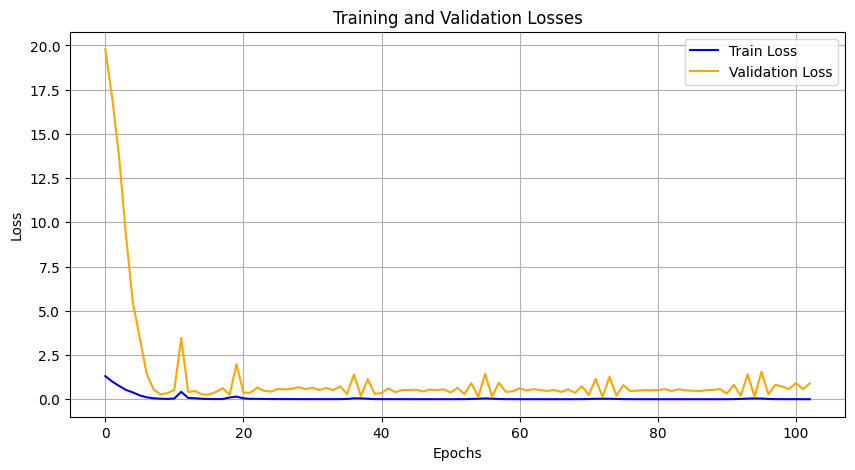

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Test phase
model.eval()
test_loss = 0.0
test_predictions = []
test_targets = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()

        test_predictions.extend(outputs.cpu().numpy())
        test_targets.extend(batch_y.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.6f}')

# Convert to numpy arrays for analysis
test_predictions = np.array(test_predictions)
test_targets = np.array(test_targets)

Test Loss: 0.291807


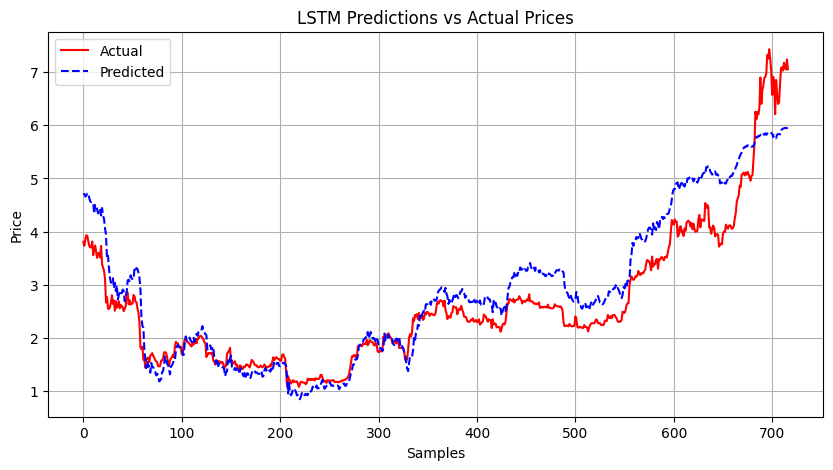

In [13]:
# plot predictions vs targets
plt.figure(figsize=(10, 5))
plt.plot(test_targets, label='Actual', color='red')
plt.plot(test_predictions, label='Predicted', color='blue', linestyle='--')
plt.xlabel('Samples')
plt.ylabel('Price')
plt.title('LSTM Predictions vs Actual Prices')
plt.legend()
plt.grid()
plt.show()